In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

images_names = [item for item in listdir('images/') if isfile(join('images/', item))]
mask_names = [item for item in listdir('images_masks/') if isfile(join('images_masks/', item))]


mask_names = [mask[:-9] for mask in mask_names]

images_names = [name[:-4] for name in images_names]

print(images_names.index("PAT_585_1130_552"))
combined_list = mask_names + images_names
unique_elements = []

for element in combined_list:
    if element not in mask_names or element not in images_names:
        unique_elements.append(element)


print(unique_elements)

634
['.DS_S']


In [5]:
df_own_features = pd.read_excel("metadata_with_feature_annotations.xlsx", sheet_name=2, header=0)

# df_own_features['assymmetry_own'] = df_own_features['assymmetry_own'] / 2.6
# df_own_features['color'] = df_own_features['color'] / 0.5


,img_id_,color,assymmetry_own
0,PAT_1516_1765_530.png,0.0,0.0
1,PAT_46_881_939.png,1.0,1.3
2,PAT_1545_1867_547.png,1.0,2.6
3,PAT_684_1302_588.png,1.0,0.0
4,PAT_1549_1882_230.png,1.0,1.3
...,...,...,...
87,PAT_430_848_476.png,1.5,2.6
88,PAT_419_832_706.png,1.5,2.6
89,PAT_1423_1472_18.png,0.5,2.6
90,PAT_55_84_506.png,1.5,0.0


In [83]:
df_own_features['color'] = df_own_features['color'] / 0.5

In [21]:
import os

from MyModel import ProcessImages
import matplotlib.pyplot as plt


#################
### COMSTANTS ###
#################

file_data = 'metadata_withmasks.csv'
image_folder = 'test_images' + os.sep
mask_folder = 'test_images_mask' + os.sep
file_features = 'feature_data.csv'

df_features = pd.read_csv(file_features)

df_features_sorted = df_features.sort_values('img_id')
df_own_features_sorted = df_own_features.sort_values('img_id_')

df_features_sorted.reset_index(drop=True, inplace=True)
df_own_features_sorted.reset_index(drop=True, inplace=True)

frames = [df_features_sorted, df_own_features_sorted]
df_concated = pd.concat(frames, axis=1)

df_concated = df_concated[df_concated["assymmetry_own"] == 1]

my_list = df_concated.assymmetry.tolist()

df_concated = df_concated.sort_values('assymmetry')
df_concated
# asym1 = df_features_sorted.assymmetry.tolist()
# asym2 = df_own_features_sorted.assymmetry.tolist()



# print(asym1)
# print("-----------------------------------")
# print(asym2)

# plt.scatter(asym1, asym2)

NameError: name 'df_own_features' is not defined

(300, 300)


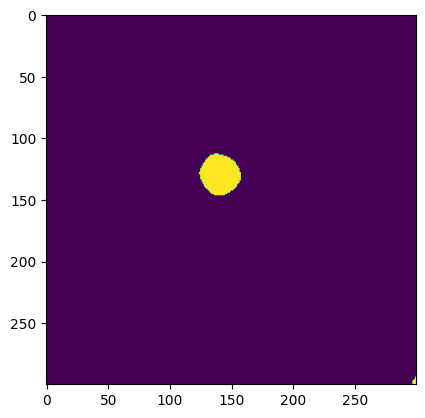

In [26]:
import os

from MyModel import ProcessImages
from prep_image import prep_im_and_mask
import matplotlib.pyplot as plt

#################
### COMSTANTS ###
#################
file_data = 'metadata_withmasks.csv'
image_folder = 'images' + os.sep
mask_folder = 'images_masks' + os.sep
file_features = 'feature_data.csv'

im, mask = prep_im_and_mask("PAT_1305_4097_251.png", image_folder, mask_folder)
im1, mask1 = prep_im_and_mask("PAT_1461_1600_867.png", image_folder, mask_folder)

print(mask.shape)
plt.imshow(mask)

In [2]:
# Feature extraction
from asymmetry import mean_asymmetry
from color import slic_segmentation, rgb_var, hsv_var, color_dominance
from compactness import compactness_score
from convexity import convexity_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv(file_data)

# Remove images without masks
df_mask = df['mask'] == 1
df = df.loc[df_mask]


def extract_features(im, im_mask):

	# Assymmetry
	asymmetry = mean_asymmetry(im_mask,4)

	# Color variance
	segments = slic_segmentation(im, im_mask)
	red_var, green_var, blue_var = rgb_var(im, segments)
	hue_var, sat_var, val_var = hsv_var(im, segments)

	# Color dominance
	dom_colors = color_dominance(im, im_mask, clusters=5, include_ratios=True) # Extract five most dominent colors, sorted by percentage of total area
	dom_hue, dom_sat, dom_val = dom_colors[0][1]     

	# Compactness
	compactness = compactness_score(im_mask)

	# Convexity
	convexity = convexity_score(im_mask)

	return [asymmetry, red_var, green_var, blue_var, \
		hue_var, sat_var, val_var, dom_hue, dom_sat, dom_val, \
		compactness, convexity]


extract_features(im1, mask1)
# mylist = list(df['img_id'])

# mylist[70]

/Users/hugohoydal/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


[0.080175,
 0.004886532403515878,
 0.00512445383527042,
 0.0061272608774972336,
 0.09529572254523888,
 0.005720938955592519,
 0.004741324438730219,
 0.055585563,
 0.06599762,
 0.5338385,
 0.722,
 0.064]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Statistics
from statistics import variance, stdev
from scipy.stats import circmean, circvar, circstd
from math import nan

# Image processing
from skimage.segmentation import slic
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans

# Own modules
from cut import cut_im_by_mask


cut_im = cut_im_by_mask(im1, mask1) # Cut image to remove excess skin pixels
hsv_im = rgb2hsv(cut_im) # Convert image to HSV color space
flat_im = np.reshape(hsv_im, (-1, 3)) # Flatten image to 2D array

# Use KMeans to cluster image by colors
k_means = KMeans(n_clusters=5, random_state=0)
k_means.fit(flat_im)

# Save cluster centers (dominant colors) in array
dom_colors = np.array(k_means.cluster_centers_, dtype='float32') 

counts = np.unique(k_means.labels_, return_counts=True)[1] # Get count of each dominent color
ratios = counts / flat_im.shape[0] # Get percentage of total image for each dominent color
# print(ratios)
# print(dom_colors)
r_and_c = zip(ratios, dom_colors) # Percentage and colors
r_and_c = sorted(r_and_c,key=lambda x: x[0], reverse= True) # Sort in descending order

r_and_c


# list_1 = [1, 2, 3, 3]
# list_2 = [[1, 3], [3, 4], [4, 6], [6, 6]]

# zip3 = zip(list_1, list_2)

# zip3 = sorted(zip3)

# zip3

# plt.imshow(im)

[(0.34924320605435155,
  array([0.05558556, 0.06599762, 0.5338385 ], dtype=float32)),
 (0.22557619539043688,
  array([0.06275462, 0.2354895 , 0.385296  ], dtype=float32)),
 (0.18283453732370142,
  array([0.13315374, 0.08380914, 0.3974588 ], dtype=float32)),
 (0.1720846233230134,
  array([0.95187545, 0.062738  , 0.5616328 ], dtype=float32)),
 (0.07026143790849673,
  array([0.44415718, 0.05271113, 0.4359557 ], dtype=float32))]

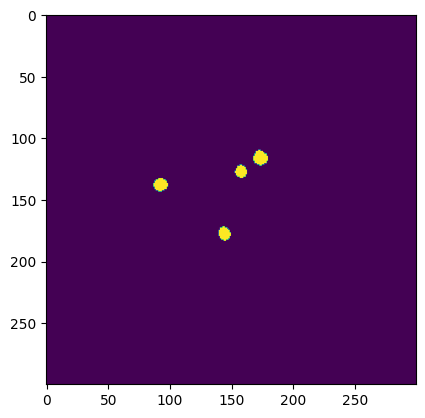

In [30]:
# Image processing
from skimage import morphology

from compactness import show_border

# Pi
from math import pi

###################
### COMPACTNESS ###
###################

def compactness_score(mask):
    '''Computes a compactness score for the given mask.
    The score is based of the Polsby-Popper measure. 
    The score falls between the value 0 and 1. Scores closer to 1 indicates a more compact mask.

    Args:
        mask (numpy.ndarray): input masked image
    
    Returns:
        compactness_score (float): Float between 0 and 1 indicating compactness. 
    '''

     #Area of ground truth 
    A = np.sum(mask)

    #Structural element, that we will use as a "brush" on our mask
    struct_el = morphology.disk(2)

    # Use this "brush" to erode the image - eat away at the borders
    mask_eroded = morphology.binary_erosion(mask, struct_el)

    #Finding the perimeter of the ground truth
    perimeter_gt = mask - mask_eroded

    #Length of the perimeter
    l = np.sum(perimeter_gt)

    compactness = (4*pi*A)/(l**2)

    score = round(1-compactness, 3)

    return compactness


    #Finding the perimeter of the ground truth
    perimeter_gt = mask - mask_eroded

    return plt.imshow(perimeter_gt, cmap='gray')

df_features.sort_values(by = ["convexity"], ascending=False)

im3, mask3 = prep_im_and_mask("PAT_513_965_496.png", image_folder, mask_folder)

plt.imshow(mask3)

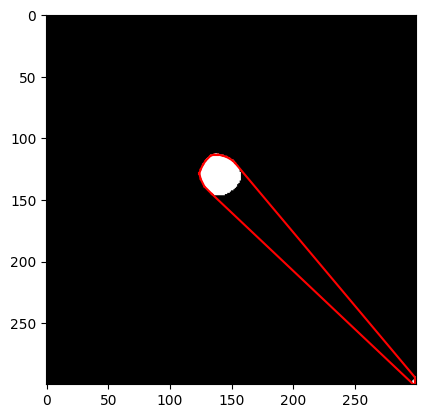

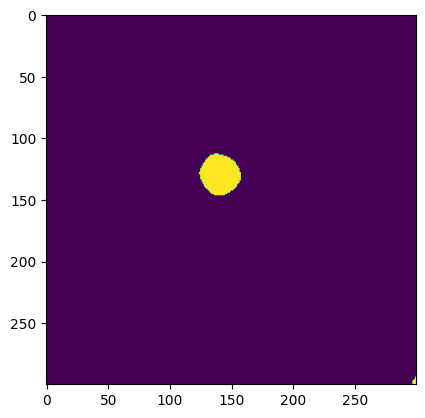

In [18]:
from scipy.spatial import ConvexHull
from convexity import plot_convex_hull

#################
### CONVEXITY ###
#################

def convexity_score(mask):
    '''Calculate convexity score between 0 and 1, 
    with 0 indicating a smoother border and 1 a more crooked border.

    Args:
        image (numpy.ndarray): input masked image
    
    Returns:
        convexity_score (float): Float between 0 and 1 indicating convexity.    
    '''

    # Get coordinates of all pixels in the lesion mask
    coords = np.transpose(np.nonzero(mask))

    # Compute convex hull of lesion pixels
    hull = ConvexHull(coords)

    # Compute area of lesion mask
    lesion_area = np.count_nonzero(mask)

    # Compute area of convex hull
    convex_hull_area = hull.volume + hull.area

    # Compute convexity as ratio of lesion area to convex hull
    convexity = lesion_area / convex_hull_area
    
    return round(1-convexity, 3)

plot_convex_hull(mask)

plt.imshow(mask)